In [1]:
from multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

import torch
from torch import nn
from torch.utils.data import TensorDataset, Dataset, DataLoader
from torch.optim import SGD, Adam
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision import datasets
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

# import wandb
# wandb.init(name='CNN-Single-Layer', project='FMNIST', tags=['DNN'])
# config = wandb.config

## Data

In [2]:
from torchvision import datasets
from loguru import logger
import torch

data_folder = '~/data/FMNIST'
fmnist = datasets.FashionMNIST(data_folder, download=True)
tr_images = fmnist.data
tr_targets = fmnist.targets

fmnist = datasets.FashionMNIST(data_folder, download=True, train=False)
val_images = fmnist.data
val_targets = fmnist.targets
unique_values = tr_targets.unique()
labels = fmnist
print(f'tr_images & tr_targets:\n\tX - {tr_images.shape}\n\tY - {tr_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'val_images & val_targets:\n\tX - {val_images.shape}\n\tY - {val_targets.shape}\n\tY - Unique Values : {unique_values}')
print(f'TASK:\n\t{len(unique_values)} class Classification')
print(f'UNIQUE CLASSES:\n\t{fmnist.classes}')

logger.info(f'Loaded the variables - {[i for i in dir() if isinstance(i, torch.Tensor)]} into environment')

2020-01-12 12:29:00.101 | INFO     | __main__:<module>:20 - Loaded the variables - [] into environment


tr_images & tr_targets:
	X - torch.Size([60000, 28, 28])
	Y - torch.Size([60000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
val_images & val_targets:
	X - torch.Size([10000, 28, 28])
	Y - torch.Size([10000])
	Y - Unique Values : tensor([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
TASK:
	10 class Classification
UNIQUE CLASSES:
	['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


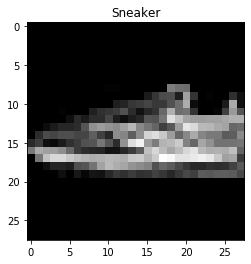

In [3]:
ix = np.random.randint(len(tr_images))
plt.imshow(tr_images[ix], cmap='gray')
plt.title(fmnist.classes[tr_targets[ix]]);

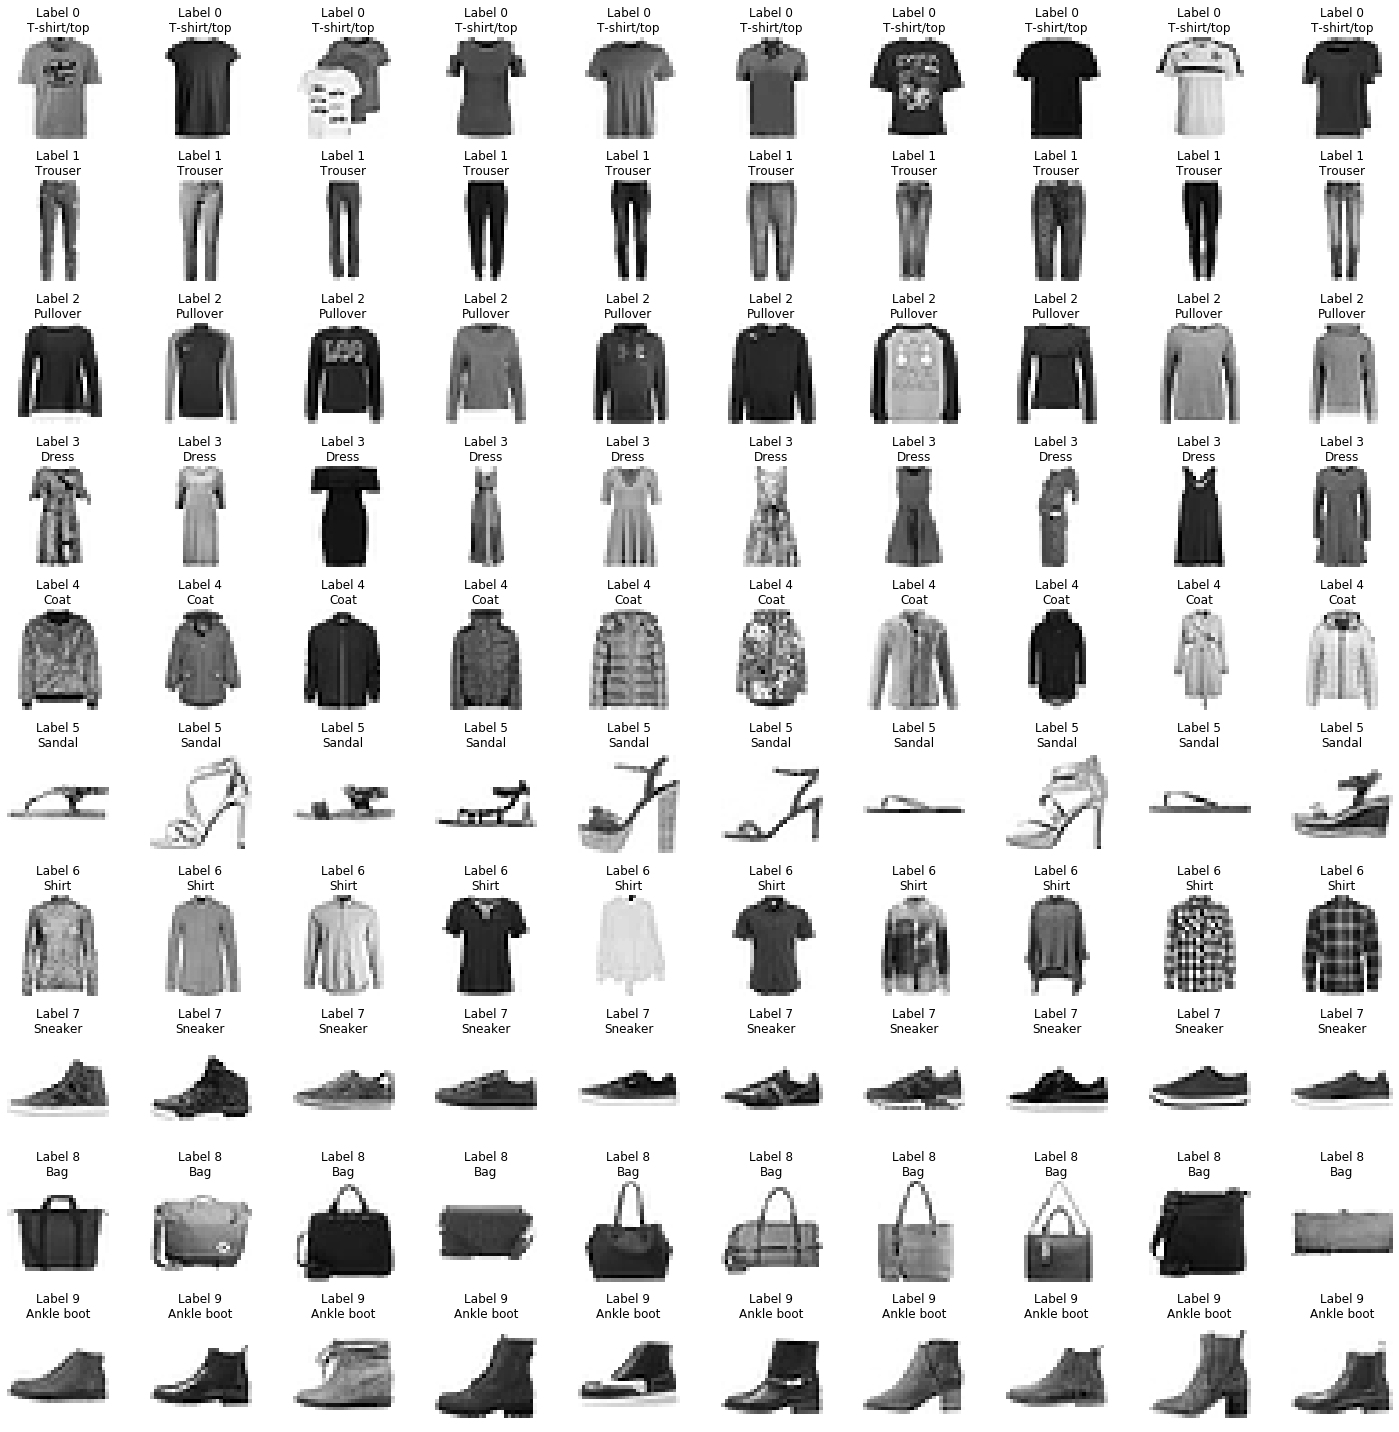

In [4]:
R, C = len(tr_targets.unique()), 10
fig, ax = plt.subplots(R, C, figsize=(20,20))

for label_class, plot_row in enumerate(ax):
    label_x_rows = np.where(tr_targets == label_class)[0]
    for plot_cell in plot_row:
        plot_cell.grid(False); plot_cell.axis('off')
        ix = np.random.choice(label_x_rows)
        x, y = tr_images[ix], tr_targets[ix]
        plot_cell.imshow(x, cmap='gray_r')
        plot_cell.set_title(f'Label {y}\n{fmnist.classes[y]}')
plt.tight_layout()

### Data Loaders

In [5]:
import imgaug as ia
from imgaug import augmenters as iaa

# tfm = iaa.Sequential([iaa.Affine(translate_px={'x':(-5,5)}, mode='reflect'), iaa.Resize(28)])

class ImgAugTransform:
    def __init__(self):
        self.aug = iaa.Sequential([
            iaa.Affine(translate_px={'x':(-10,10)}, mode='constant'),
        ])
    def __call__(self, img):
        return self.aug.augment_image(img)

tfm = ImgAugTransform()

class FMNISTDataset(Dataset):
    def __init__(self, x, y, transform=tfm):
        self.x, self.y = x.cpu().numpy(), y
        self.tfm = tfm
    def __getitem__(self, ix):
        x, y = self.x[ix]/255., self.y[ix]
        x = tfm(x) if self.tfm is not None else x
        return torch.tensor(x[None]).float().to(device), y.to(device)
    def __len__(self): return len(self.x)

def get_data(NORMALIZATION, batch_size=128):
    if not NORMALIZATION:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        train = TensorDataset(tr_images.float().to(device), tr_targets.float().to(device))
        val = TensorDataset(val_images.float().to(device), val_targets.float().to(device))
        print(f'Train:\t{len(train)} images\nVal:\t{len(val)} images')

        trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val, batch_size=batch_size, shuffle=False)

    else:
        train = FMNISTDataset(tr_images, tr_targets)
        val = FMNISTDataset(val_images, val_targets, transform=None)
        
        trn_dl = DataLoader(train, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(val, batch_size=batch_size, shuffle=False)
    return trn_dl, val_dl

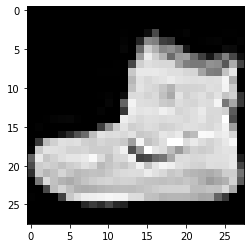

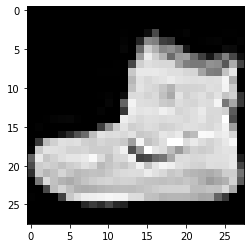

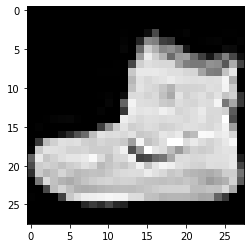

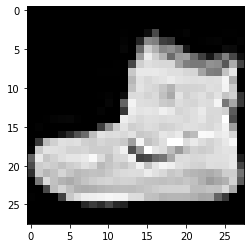

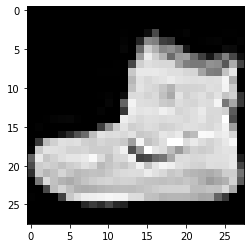

In [6]:
d = FMNISTDataset(tr_images, tr_targets)
for _ in range(5):
    im, c = d[0]
    plt.imshow(im.cpu()[0], cmap='gray')
    plt.show()

## Architecture, Loss and Optimizer

In [7]:
def get_model():
    model = nn.Sequential(
        nn.Conv2d(1, 10, kernel_size=3),
        nn.MaxPool2d(2),
        nn.Conv2d(10, 20, kernel_size=3),
        nn.MaxPool2d(2),
        nn.ReLU(),
        nn.Flatten(),
        nn.Linear(500, 256),
        nn.ReLU(),
        nn.Linear(256, 10)
    ).to(device)

    loss_fn = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr=1e-3)
    return model, loss_fn, optimizer

from torchsummary import summary
model, loss_fn, optimizer = get_model()
summary(model, input_size=(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
         MaxPool2d-2           [-1, 10, 13, 13]               0
            Conv2d-3           [-1, 20, 11, 11]           1,820
         MaxPool2d-4             [-1, 20, 5, 5]               0
              ReLU-5             [-1, 20, 5, 5]               0
           Flatten-6                  [-1, 500]               0
            Linear-7                  [-1, 256]         128,256
              ReLU-8                  [-1, 256]               0
            Linear-9                   [-1, 10]           2,570
Total params: 132,746
Trainable params: 132,746
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.51
Estimated Total Size (MB): 0.61
-------------------------------------------

### Prediction Loop

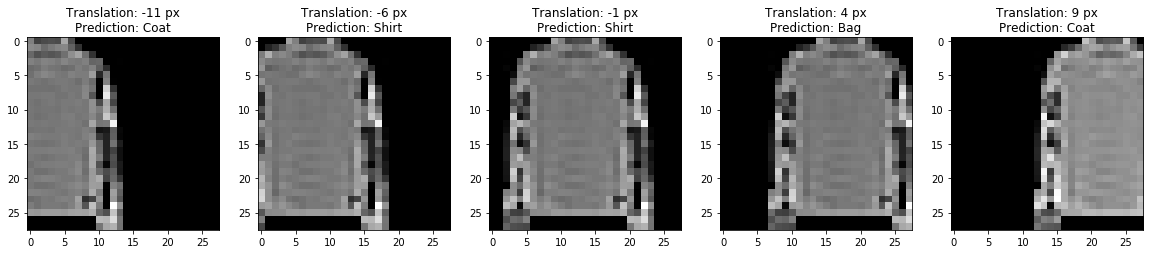

In [8]:
model = torch.load('fmnist-aug.pth').cpu()

import imgaug as ia
from imgaug import augmenters as iaa

tfm = lambda translate_px: iaa.Sequential([
    iaa.Affine(translate_px={'x': translate_px}, mode='constant')
])

ix = np.random.randint(len(val_images))
im = val_images[ix].numpy()
fig, ax = plt.subplots(1, 5, figsize=(20,4))
for ix, px in enumerate(range(-11, 10, 5)):
    tfm_ = tfm(px)
    translated_image = tfm_.augment_image(im)
    pred = model(torch.tensor(translated_image)[None,None].float())[0]
    _, argmax = pred.max(0)
    info = f'Translation: {px} px\nPrediction: {fmnist.classes[argmax]}'
    ax[ix].imshow(translated_image, cmap='gray')
    ax[ix].set_title(info)


## Training Loop

In [8]:
def train_batch(x, y, model, opt, loss_fn):
    'call your model like any python function on your batch of inputs'
    prediction = model(x)
    is_correct = prediction.max(-1)[1] == y
    'compute loss'
    batch_loss = loss_fn(prediction, y)
    'based on the forward pass in `model(x)` compute all the gradients of `model.parameters()`'
    batch_loss.backward()
    'apply new-weights = f(old-weights, old-weight-gradients) where "f" is the optimizer.'
    optimizer.step()
    optimizer.zero_grad()
    return batch_loss.item(), is_correct
def validate_batch(x, y, model, loss_fn):
    'just do a forward pass and store the losses for the entire batch'
    prediction = model(x)
    'compute if the location of maximum in each row coincides with ground truth'
    is_correct = prediction.max(-1)[1] == y
    batch_loss = loss_fn(prediction, y)
    return batch_loss.item(), is_correct

In [9]:
import time, dill
trn_dl, val_dl = get_data(NORMALIZATION=True)

# model, loss_fn, optimizer = get_model()
# wandb.watch(model, log='all')

best_val_acc = -1
for epoch in range(10):
    start = time.time()
    N_trn = len(trn_dl)
    train_losses, val_losses, train_acc, val_acc = [], [], [], []
    for ix, batch in enumerate(trn_dl):
        x, y = batch
        batch_loss, corrects = train_batch(x, y, model, optimizer, loss_fn)
        train_losses.append(batch_loss)
        train_acc.extend(corrects.tolist())
        print(f'{ix}/{N_trn}, Loss: {batch_loss:.3f}', end='\r')

    N_val = len(val_dl)
    for ix, batch in enumerate(val_dl):
        print(f'Testing {ix}/{N_val}', end='\r')
        x, y = batch
        batch_loss, corrects = validate_batch(x, y, model, loss_fn)
        val_losses.append(batch_loss)
        val_acc.extend(corrects.tolist())
        
    # wandb.log({'train_loss': np.mean(train_losses), 
    #            'valid_loss': np.mean(val_losses), 
    #            'train_acc': np.mean(train_acc),
    #            'valid_acc': np.mean(val_acc)})
    
    print(f'Epoch: {epoch+1:3d}, Train Loss: {np.mean(train_losses):.3f}, Validation Loss: {np.mean(val_losses):.3f}, Train Acc: {np.mean(train_acc)*100:.2f}%, Validation Acc: {np.mean(val_acc)*100:.2f}% Time: {time.time()-start:.0f} seconds')


Epoch:   1, Train Loss: 0.648, Validation Loss: 0.480, Train Acc: 76.55%, Validation Acc: 82.75% Time: 5 seconds
Epoch:   2, Train Loss: 0.426, Validation Loss: 0.415, Train Acc: 84.47%, Validation Acc: 84.84% Time: 5 seconds


KeyboardInterrupt: 

In [ ]:
trn_dl.dataset[0]

In [ ]:
next(iter(trn_dl))

In [ ]:
torch.save(model, 'fmnist-aug.pth')